# Experimentación - VIRUS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target)
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


df = pd.read_csv("expectativa_de_vida.csv")

#### Como la cantidad de filas (países) en el dataset no es demasiado significativa (miles y miles de elementos), no haré un train set que intente ser un fiel representante de todos los datos de la tabla. Sino que utilizaré a todos los países del dataset para realizar experimentos. 
#### En algunos casos, en vez de incluir a todos, me centraré en ciertos grupos en especifico, excluyendo a toda la muestra. Pero esto será con la intención de querer demostrar cierta anomalía o dato interesante que nos puedan proveer los datos. Como ejemplo, veré como segmentar y emplear regresión sólo con paises con información sobre virus. También habrá un modelo donde no haya outliers. Se trataran a los outliers con suficiente detenimiento para entender su condición. ¿Por qué se salen tanto de la norma? ¿Son creibles sus datos? ¿O simplemente están encasillados en una categoría que no les corresponde si se la compara con el resto de su información?

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       183 non-null    int64  
 1   Country                          183 non-null    object 
 2   Life expectancy                  183 non-null    float64
 3   Adult Mortality                  183 non-null    float64
 4   infant deaths                    183 non-null    float64
 5   Alcohol                          182 non-null    float64
 6   percentage expenditure           183 non-null    float64
 7   Hepatitis B                      174 non-null    float64
 8   Measles                          183 non-null    float64
 9   BMI                              181 non-null    float64
 10  under-five deaths                183 non-null    float64
 11  Polio                            183 non-null    float64
 12  Total expenditure     

### Vemos que 'Status' es de tipo object, no float, como nos es de interés incluirlo en la experimentación, próximamente vamos a hacer que tenga un valor numérico.

### Gracias al análisis exploratorio de datos provisto en 'EDA.ipynb' se podría descartar la siguiente data:

#### <b>Features 
 - **Hepatitis B**: Se correlaciona mucho con Polio y Diphteria
 - **Alcohol**: No parece ser un indicador que ayude a explicar la expectativa de vida
 - **GDP**: Puede ser reemplazado por Percentage Expenditure
 - **Population**: Se puede reemplazar por Infant Deaths y Under-Five Deaths
 - **Income Composition of Resources y Schooling**: Ambos correlacionan fuerte con BMI

#### <b> Paises
 - **Sudan, Sudan del Sur, Corea del Norte y Somalia**: Todos ellos tienen data incompleta

### Saco a los países nombrados más arriba del dataset

In [3]:
df_new = df.drop([150, 153, 44, 148], axis=0)

In [4]:
print(df.shape) # Con todos los paises
print(df_new.shape) # Sin esos paises

(183, 22)
(179, 22)


### Hago que 'Status' tenga un valor float

In [5]:
df_new['Status_Float'] = df_new['Status'].apply(lambda x: 0 if x=='Developing' else 1)

In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 182
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       179 non-null    int64  
 1   Country                          179 non-null    object 
 2   Life expectancy                  179 non-null    float64
 3   Adult Mortality                  179 non-null    float64
 4   infant deaths                    179 non-null    float64
 5   Alcohol                          179 non-null    float64
 6   percentage expenditure           179 non-null    float64
 7   Hepatitis B                      170 non-null    float64
 8   Measles                          179 non-null    float64
 9   BMI                              179 non-null    float64
 10  under-five deaths                179 non-null    float64
 11  Polio                            179 non-null    float64
 12  Total expenditure     

## Busco variables para mis muestras de regresión: Empiezo con el data set que contiene a todos los países

In [7]:
df_new.corr()['Life expectancy']

Unnamed: 0                         0.009284
Life expectancy                    1.000000
Adult Mortality                   -0.892716
infant deaths                     -0.200913
Alcohol                            0.453856
percentage expenditure             0.523687
Hepatitis B                        0.402502
Measles                           -0.203355
BMI                                0.722210
under-five deaths                 -0.226052
Polio                              0.668041
Total expenditure                  0.279391
Diphtheria                         0.658709
HIV/AIDS                          -0.598270
GDP                                0.609940
Population                        -0.042260
thinness  1-19 years              -0.523232
thinness 5-9 years                -0.515666
Income composition of resources    0.814026
Schooling                          0.794511
Status_Float                       0.500508
Name: Life expectancy, dtype: float64

## Experimentación 1: Modelo - Enfermedades

### Como el COVID fue por lejos el acontecimiento más relevante del 2020 y el 2021, centraremos esta etapa de la investigacion en cómo se relaciona la expectativa de vida a comparación con qué tan propenso es contraer un virus (serio si no es tratado) en dicho país. 

### Vamos a unir en una sola variable todos los virus que aparecen en la tabla, para ver cómo se correlacionan las enfermedades con la expectativa de vida de un país. Qué países se espera que se vean más afectados, y si puede llegar a haber casos extremos que no preveíamos o no condicen con nuestros pensamientos previos al estudio.

### Primero veo como son los datos de cada columna de virus.

In [8]:
df_new['HIV/AIDS']

0       0.10000
1       0.10000
2       0.10000
3       2.36875
4       0.12500
         ...   
178     0.10000
179     0.14375
180     0.10000
181    11.93125
182    23.26250
Name: HIV/AIDS, Length: 179, dtype: float64

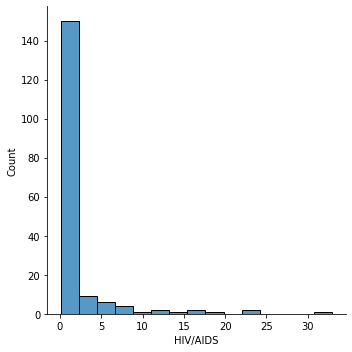

In [9]:
sns.displot(df_new, x='HIV/AIDS', bins=15)

### Pareciera que es un dato que la mayoría de países lo tiene por debajo de '2'. Si vemos la data de correlación sobre Life expectancy, vemos que el HIV se correlaciona negativamente. Por lo que a mayor es el valor de la celda HIV, menor será la expectativa de vida de dicho país.

### Veamos que sucede con el Hepatitis B

In [10]:
df_new['Hepatitis B']

0      64.562500
1      98.000000
2      78.000000
3      70.222222
4      98.266667
         ...    
178    66.250000
179    87.538462
180    55.687500
181    69.818182
182    70.562500
Name: Hepatitis B, Length: 179, dtype: float64

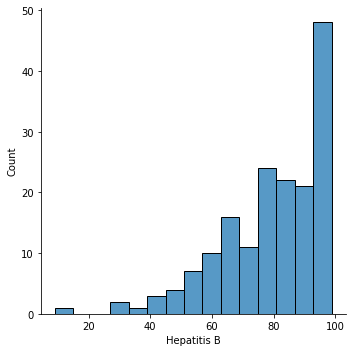

In [11]:
sns.displot(df_new, x='Hepatitis B', bins=15)

### Acá vemos que los valores se reparten entre el 0 y el 100. La escala es diferente a la del caso de HIV, donde pareciera que los valores estan "más normalizados". Acá la forma del histograma es distinta también, que tiene una forma creciente, mientras el histograma anterior tiene una forma decreciente. Esto nos muestra que el Hepatitis B esta correlacionado positivamente con la expectativa de vida.

### Por último veamos 'Measles'.

In [12]:
df_new['Measles']

0      2362.2500
1        53.3750
2      1943.8750
3      3561.3125
4         0.0000
         ...    
178     165.0000
179    4232.9375
180    2761.1875
181    6563.8125
182     923.0000
Name: Measles, Length: 179, dtype: float64

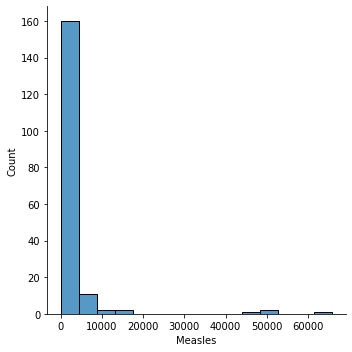

In [13]:
sns.displot(df_new, x='Measles', bins=15)

### Los valores son muy dispares. Hay muchos casos extremos. Quiero ver como se ven los datos que tienen un valor entre 0 y 10000.

In [14]:
df_measles = df_new[df_new['Measles'] < 10000]

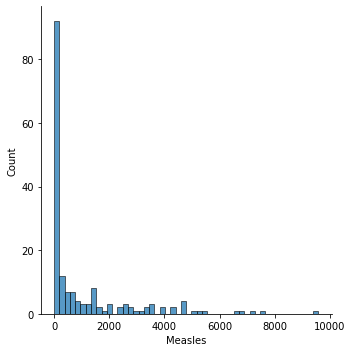

In [15]:
sns.displot(df_measles, x='Measles', bins=50)

### Sigue habiendo mucha disparidad. ¿Y los que son menores a 1000?

In [16]:
df_measles = df_new[df_new['Measles'] < 1000]

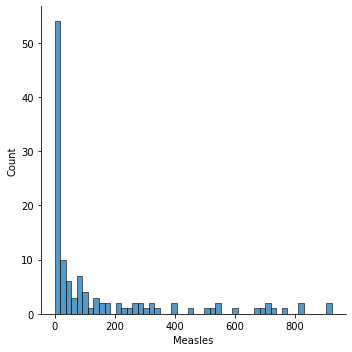

In [17]:
sns.displot(df_measles, x='Measles', bins=50)

### La tendencia es la misma. Es decreciente, como el HIV.

### Veamos los casos extremos, estos (seguramente) van a ser los outliers de mi modelo.

In [18]:
df_new[df_new['Measles'] > 20000]

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Status_Float
34,34,China,74.26250,73.7500,294.8750,4.182000,73.583763,80.437500,65857.9375,21.80625,...,93.3125,0.10000,2345.303158,3.218121e+05,4.63750,4.02500,0.660250,11.43750,Developing,0
45,46,Democratic Republic of the Congo,55.68750,265.3750,234.5000,1.424000,0.000000,51.333333,48922.6875,15.83750,...,41.8750,1.81875,NaN,NaN,8.14375,7.95625,NaN,NaN,Developing,0
74,76,India,65.41875,146.5625,1366.6875,1.942000,33.242621,35.000000,46454.1875,14.79375,...,67.0625,0.25625,837.920051,4.214677e+08,27.10000,27.94375,0.549500,9.98125,Developing,0
118,123,Nigeria,51.35625,248.5000,535.6875,8.646667,85.444275,42.909091,51653.9375,19.75000,...,39.3125,4.83125,1360.139877,7.087700e+07,10.41875,10.36875,0.367375,9.00000,Developing,0


## Normalizo

### Antes que nada, normalizo los datos de las enfermedades ('Measles', 'HIV/AIDS', 'Polio' y 'Hepatitis B'). Ya vi anteriormente que tienen escalas muy distintas y se correlacionan de manera diferente con la expectativa de vida. Por lo tanto, al normalizarlas obtengo una misma escala para cada enfermedad, y luego las sumo acorde a la correlación que tengan con la categoría 'Life expectancy'.

In [19]:
features_a_normalizar = ['Measles','HIV/AIDS', 'Polio', 'Hepatitis B', 'Life expectancy']
for feature in features_a_normalizar:
    df_new[f'Normalizado_{feature}'] = (df_new[feature]-np.mean(df_new[feature]))/np.std(df_new[feature])

In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 182
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       179 non-null    int64  
 1   Country                          179 non-null    object 
 2   Life expectancy                  179 non-null    float64
 3   Adult Mortality                  179 non-null    float64
 4   infant deaths                    179 non-null    float64
 5   Alcohol                          179 non-null    float64
 6   percentage expenditure           179 non-null    float64
 7   Hepatitis B                      170 non-null    float64
 8   Measles                          179 non-null    float64
 9   BMI                              179 non-null    float64
 10  under-five deaths                179 non-null    float64
 11  Polio                            179 non-null    float64
 12  Total expenditure     

### Me deshago de los países que no contengan data sobre el Hepatitis B. Los busco y me armo mi modelo personalizado 'df_virus'.

In [21]:
df_virus = df_new[(pd.notnull(df_new["Hepatitis B"]))] 

### Armo el modelo nuevo

In [22]:
df_virus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 182
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       170 non-null    int64  
 1   Country                          170 non-null    object 
 2   Life expectancy                  170 non-null    float64
 3   Adult Mortality                  170 non-null    float64
 4   infant deaths                    170 non-null    float64
 5   Alcohol                          170 non-null    float64
 6   percentage expenditure           170 non-null    float64
 7   Hepatitis B                      170 non-null    float64
 8   Measles                          170 non-null    float64
 9   BMI                              170 non-null    float64
 10  under-five deaths                170 non-null    float64
 11  Polio                            170 non-null    float64
 12  Total expenditure     

In [23]:
df_virus['enfermedades_all'] = df_virus['Normalizado_Measles'] + df_virus['Normalizado_HIV/AIDS'] - df_virus['Normalizado_Polio'] - df_virus['Normalizado_Hepatitis B'] 

<ipython-input-23-189cfb570861>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_virus['enfermedades_all'] = df_virus['Normalizado_Measles'] + df_virus['Normalizado_HIV/AIDS'] - df_virus['Normalizado_Polio'] - df_virus['Normalizado_Hepatitis B']


In [24]:
df_virus.corr()["Life expectancy"] #Vemos una correlacion aceptable entre los distintos virus que hay y la expectativa de vida

Unnamed: 0                        -0.009464
Life expectancy                    1.000000
Adult Mortality                   -0.887393
infant deaths                     -0.193155
Alcohol                            0.415487
percentage expenditure             0.511175
Hepatitis B                        0.402502
Measles                           -0.201311
BMI                                0.724400
under-five deaths                 -0.219068
Polio                              0.659608
Total expenditure                  0.230055
Diphtheria                         0.652492
HIV/AIDS                          -0.601532
GDP                                0.585880
Population                        -0.023562
thinness  1-19 years              -0.496203
thinness 5-9 years                -0.487267
Income composition of resources    0.798249
Schooling                          0.779184
Status_Float                       0.451057
Normalizado_Measles               -0.201311
Normalizado_HIV/AIDS            

### Al sumar las variables vemos que a mayor incidencia de un virus, menor la expectativa de vida, por eso la correlación es negativa.

### Corro el análisis de regresión. 

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     144.8
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           1.87e-24
Time:                        01:15:31   Log-Likelihood:                -560.93
No. Observations:                 170   AIC:                             1126.
Df Residuals:                     168   BIC:                             1132.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.0116      0.506    136.363      0.0

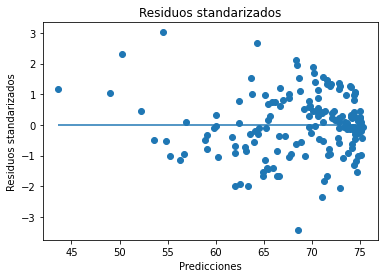

<Figure size 2160x2160 with 0 Axes>

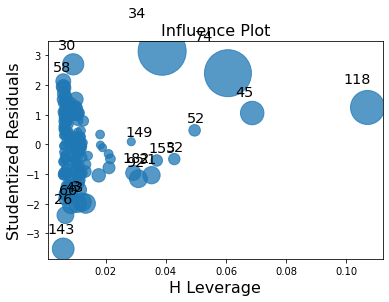

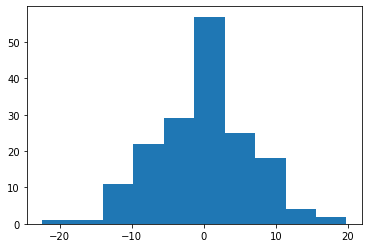

{'r2': 0.4629982712326227,
 'rmse': 6.557675023120022,
 'adjusted': 0.4598018323709121}

In [25]:
run_analysis(['enfermedades_all'], df_virus)

### Grafico con el método de cuadrados mínimos.

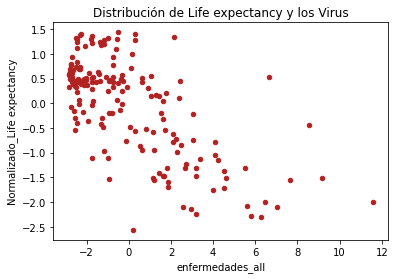

In [26]:
fig_virus, ax_virus = plt.subplots()

df_virus.plot(
    x    = 'enfermedades_all',
    y    = 'Normalizado_Life expectancy',
    c    = 'firebrick',
    kind = "scatter",
    ax   = ax_virus
)

#ACA PONDRIA LA RECTA DE REGRESION CON LA FUNCION DE C++ !!!FALTA ESTO!!!

ax_virus.set_title('Distribución de Life expectancy y los Virus');

## Busqueda de outliers

### Quito outliers y vuelvo a hacer el análisis para ver como cambian los datos arrojados.

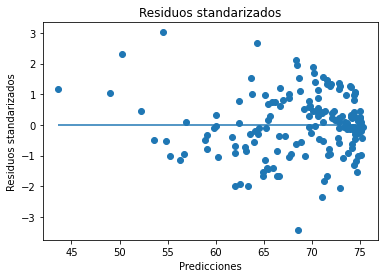

In [27]:
residuos_virus = residuos(['enfermedades_all'], df_virus)

/home/tincho/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

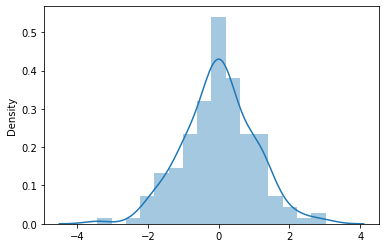

In [28]:
sns.distplot(residuos_virus)

### Como primer medida tengo que atender los casos donde el módulo del residuo sea mayor a 2 (desviación estandar), ellos son outliers. Tambien tengo que prestar atención a los casos donde el diámetro de la distancia de Cook es muy grande y la palanca que realiza ese punto (Leverage) es considerable.
### Teniendo en cuenta esos 3 casos, puedo quedarme con un modelo con un ajuste muchísimo más fiable ya que estoy dejando de lado a los casos más extremos de la muestra, que pueden complicar la estimación de todo el modelo.

In [29]:
df_virus = df_virus.assign(residuos_virus = residuos_virus)

In [30]:
#Busco outliers por el lado de los residuos
df_virus[(df_virus["residuos_virus"]**2)**0.5 > 2] 

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Schooling,Status,Status_Float,Normalizado_Measles,Normalizado_HIV/AIDS,Normalizado_Polio,Normalizado_Hepatitis B,Normalizado_Life expectancy,enfermedades_all,residuos_virus
26,26,Burundi,55.53750,291.5625,23.2500,4.103333,15.335498,93.333333,1349.5000,15.31250,...,7.48125,Developing,0,-0.132838,0.296511,0.245277,0.838538,-1.528672,-0.920142,-2.362307
30,30,Canada,81.68750,64.6250,2.0000,8.053333,4694.078971,28.846154,129.5000,55.86250,...,15.87500,Developing,0,-0.282681,-0.370526,0.159540,-2.968750,1.346474,2.156003,2.653751
34,34,China,74.26250,73.7500,294.8750,4.182000,73.583763,80.437500,65857.9375,21.80625,...,11.43750,Developing,0,7.790238,-0.370526,0.706624,0.077175,0.530109,6.635913,3.019136
58,60,France,82.21875,73.1250,2.9375,12.404667,3751.506574,51.250000,2661.6250,51.98125,...,15.90000,Developing,0,0.028320,-0.370526,1.004662,-1.646039,1.404884,0.299171,2.114019
60,62,Gambia,59.46250,249.6250,3.0000,2.134667,0.000000,95.375000,41.2500,20.30000,...,8.12500,Developing,0,-0.293520,0.130450,0.645383,0.959077,-1.097125,-1.767531,-2.047056
74,76,India,65.41875,146.5625,1366.6875,1.942000,33.242621,35.000000,46454.1875,14.79375,...,9.98125,Developing,0,5.407025,-0.335639,-0.865222,-2.605430,-0.442246,8.542038,2.307749
143,152,Sierra Leone,46.11250,357.8125,27.5625,3.154667,29.105579,83.444444,673.8750,18.30625,...,8.23125,Developing,0,-0.215820,-0.053753,-0.726409,0.254704,-2.564934,0.202133,-3.424374


### Como primer outlier destacable vemos a China, que tiene un valor normalizado de 'Measles' de 7.79, MUY por encima del resto. Nos deshacemos de el y del resto de países en esta lista. Hay que decir que son bastante pocos, por lo que el conjunto de todos los datos no se desvía mucho de la predicción.

In [31]:
df_virus_no_outliers = df_virus[(df_virus["residuos_virus"]**2)**0.5 <= 2] 

### Ahora me encargo de la distancia de Cook y el Leverage y termino de extraer a los últimos outliers.

In [32]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

In [33]:
cook_virus, p_virus = cooksDist(['enfermedades_all'], df_virus)

In [34]:
cook_virus.shape

(170,)

In [35]:
df_virus2 = df_virus.assign(cook_virus = cook_virus)

### Estos son los países con mayor distancia de Cook (circulo más grande). Los saco de la muestra. Notar que China ya había aparecido como outlier en el test de residuos.

In [36]:
df_virus2[df_virus2["cook_virus"] > 0.1]

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Status,Status_Float,Normalizado_Measles,Normalizado_HIV/AIDS,Normalizado_Polio,Normalizado_Hepatitis B,Normalizado_Life expectancy,enfermedades_all,residuos_virus,cook_virus
34,34,China,74.26250,73.7500,294.8750,4.182,73.583763,80.4375,65857.9375,21.80625,...,Developing,0,7.790238,-0.370526,0.706624,0.077175,0.530109,6.635913,3.019136,0.188995
74,76,India,65.41875,146.5625,1366.6875,1.942,33.242621,35.0000,46454.1875,14.79375,...,Developing,0,5.407025,-0.335639,-0.865222,-2.605430,-0.442246,8.542038,2.307749,0.180816


In [37]:
cook_virus_no_outliers, p_virus_no_outliers = cooksDist(['enfermedades_all'], df_virus_no_outliers)

In [38]:
df_virus_no_outliers = df_virus_no_outliers.assign(cook_virus = cook_virus_no_outliers)

In [39]:
df_virus_no_outliers = df_virus_no_outliers[df_virus_no_outliers["cook_virus"] < 0.1]

In [40]:
print(df_virus_no_outliers.shape)
print(df_virus.shape) 

(161, 31)
(170, 30)


### Ya nos deshicimos de 6 outliers, ahora veamos la condición de Leverage y terminamos con la quita. 

In [41]:
# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage

In [42]:
leverage_no_outliers = getLeverage(['enfermedades_all'], df_virus_no_outliers)

In [43]:
df_virus_no_outliers = df_virus_no_outliers.assign(leverage_virus = leverage_no_outliers)

In [44]:
df_virus_no_outliers = df_virus_no_outliers[df_virus_no_outliers["leverage_virus"] < 0.06]

In [45]:
print(df_virus_no_outliers.shape)
print(df_virus.shape) 

(160, 32)
(170, 30)


### Ya me deshice de los países con mayor Leverage. Por lo tanto terminé de eliminar los máximos outliers de la muestra. Ahora realizo el análisis de regresión sin outliers en mi modelo.

## Análisis sin outliers

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     224.8
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           3.61e-32
Time:                        01:15:39   Log-Likelihood:                -500.02
No. Observations:                 160   AIC:                             1004.
Df Residuals:                     158   BIC:                             1010.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.6955      0.440    156.224      0.0

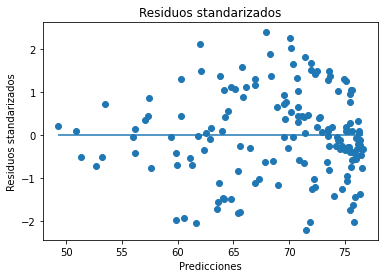

<Figure size 2160x2160 with 0 Axes>

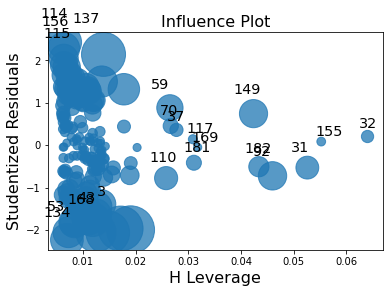

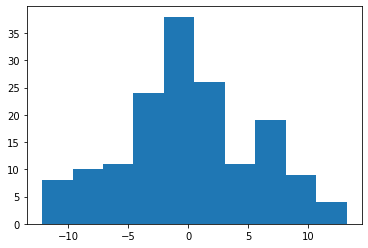

{'r2': 0.5872142489307659,
 'rmse': 5.507911265727309,
 'adjusted': 0.5846016808860239}

In [46]:
run_analysis(['enfermedades_all'], df_virus_no_outliers)

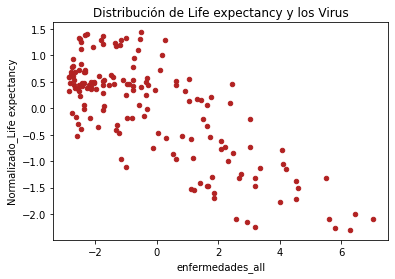

In [47]:
fig_virus_no, ax_virus_no = plt.subplots()

df_virus_no_outliers.plot(
    x    = 'enfermedades_all',
    y    = 'Normalizado_Life expectancy',
    c    = 'firebrick',
    kind = "scatter",
    ax   = ax_virus_no
)

#ACA PONDRIA LA RECTA DE REGRESION CON LA FUNCION DE C++ !!!FALTA ESTO!!! (RECTA CON OUTLIERS)
#ACA PONDRIA LA RECTA DE REGRESION CON LA FUNCION DE C++ !!!FALTA ESTO!!! (RECTA SIN OUTLIERS)

ax_virus_no.set_title('Distribución de Life expectancy y los Virus');

### Notamos como el ajuste dio muchísimo mejor. Esto demuestra que, quitando los outliers correctos, la regresión puede mejorar considerablemente.

## Analisis con status de los paises

### Hago una distincion entre el tipo de pais para ver como difiere la incidencia de la enfermedad con la expectativa de vida entre un país desarrollado y otro en vías de desarrollo.

VIF for enfermedades_all 1.088617467354242
VIF for Status_Float 1.088617467354242
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     151.9
Date:                Sat, 13 Nov 2021   Prob (F-statistic):           1.98e-37
Time:                        01:15:41   Log-Likelihood:                -484.68
No. Observations:                 160   AIC:                             975.4
Df Residuals:                     157   BIC:                             984.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

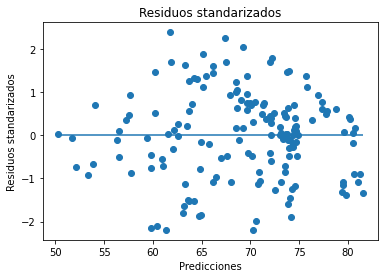

<Figure size 2160x2160 with 0 Axes>

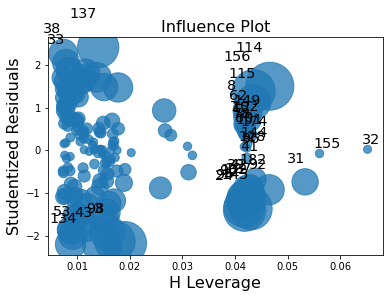

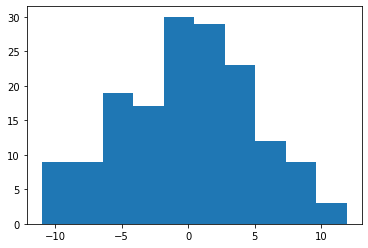

{'r2': 0.6592460362959123,
 'rmse': 5.004319673514516,
 'adjusted': 0.6549052214716564}

In [48]:
run_analysis(['enfermedades_all', 'Status_Float'], df_virus_no_outliers)

### Si realizo el análisis teniendo en cuenta el estado de un país (en desarrollo o desarrollado), la regresión es más certera y sólo agrego una variable.